In [1]:
import numpy as np


class pySineGaussian:
    def __init__(self, parameters):
        """
        Initialize class. The ``parameters`` dictionary can
        contain the following:

        Parameters
        ----------
        waveform_dict: dict
            Dictionary containing waveform parameters
        model: str
            Name of waveform model
        """
        self.params = self._validate_params(parameters)

    @staticmethod
    def _validate_params(parameters):
        default_params = {
            "amplitude": 1.0,
            "frequency": 100.0,
            "duration": None,
            "delay": 0.0,
            "sampling_rate": 16384.0,
        }

        waveform_params = parameters.copy()
        for key in default_params:
            if key not in parameters:
                waveform_params[key] = default_params[key]

        if waveform_params["duration"] is None:
            raise ValueError("Duration is not specified")

        return waveform_params

    def __call__(self):
        return self._evaluate_model()

    def _evaluate_model(self):
        sample_rate = self.params["sampling_rate"]
        delay = self.params["delay"]
        duration = self.params["duration"]
        frequency = self.params["frequency"]

        m = int(6*duration*sample_rate)
        if m > int(sample_rate)/2-1:
            m = int(sample_rate)/2-2

        t = np.arange(0, m, 1)/sample_rate
        g = 2*np.exp(-t*t/2/duration/duration)*np.sin(2*np.pi*frequency*t)
        sum = np.sum(g*g)

        amplitude = self.params["amplitude"]*np.sqrt(sample_rate/sum)

        t = np.arange(1, m, 1)/sample_rate
        g = amplitude*np.exp(-t*t/2/duration/duration)*np.sin(2*np.pi*frequency*t)

        waveform = np.concatenate((-g[::-1], np.zeros(1), g))
        return waveform


class pySineGaussianQ(pySineGaussian):
    def __init__(self, parameters):
        """
        Initialize class. The ``parameters`` dictionary can
        contain the following:

        Parameters
        ----------
        waveform_dict: dict
            Dictionary containing waveform parameters
        model: str
            Name of waveform model
        """
        parameters = self._validate_params_SGQ(parameters)
        super(pySineGaussianQ, self).__init__(parameters)

    @staticmethod
    def _validate_params_SGQ(parameters):
        default_params = {
            "amplitude": 1.0,
            "frequency": None,
            "Q": None,
        }

        waveform_params = parameters.copy()
        for key in default_params:
            if key not in parameters:
                waveform_params[key] = default_params[key]

        if waveform_params["frequency"] is None:
            raise ValueError("Frequency is not specified")

        if waveform_params["Q"] is None:
            raise ValueError("Q is not specified")

        waveform_params["duration"] = waveform_params["Q"] / (np.pi * 2 * waveform_params["frequency"])

        return waveform_params

from lalsimulation.gwsignal.core.waveform import CompactBinaryCoalescenceGenerator
from lalsimulation.gwsignal.core import gw as gw
from gwpy.timeseries import TimeSeries

class SineGaussianQ(CompactBinaryCoalescenceGenerator):
    def __init__(self, **kwargs):
        super(SineGaussianQ, self).__init__()
        self.model = pySineGaussianQ
        self._domain = "time"
        self._implemented_domain = "time"
        self._generation_domain = None

    @property
    def metadata(self):
        metadata = {
            "type": "sine_gaussian",
            "f_ref_spin": False,
            "modes": False,
            "polarizations": True,
            "implemented_domain": "time",
            "approximant": "SineGaussianQ",
            "implementation" : "Python",
            "conditioning_routines" : 'gwsignal'
        }
        return metadata

    def generate_td_modes(self, **parameters):
        return 0

    def generate_td_waveform(self, **parameters):

        gen_wf = self.model(**parameters)
        if self.waveform_dict.get("condition"):
            hp, hc = gen_wf()
        else:
            hp, hc = gen_wf()

        hp = TimeSeries(hp, t0=0, sample_rate=parameters['sample_rate'])
        hc = TimeSeries(hc, t0=0, sample_rate=parameters['sample_rate'])
        return gw.GravitationalWavePolarizations(hp=hp, hc=hc)

/Users/yumengxu/miniforge3/envs/waveform/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
import matplotlib.pyplot as plt

model = pySineGaussianQ({
    "amplitude": 1.0,
    "frequency": 300.0,
    "Q": 9 
})

wave = model()

plt.plot(wave)


In [1]:
import lalsimulation.gwsignal.core.waveform as wfm
import lalsimulation as lalsim
import lal

python_dict_nrsur = {
    "amplitude": 1.0,
    "frequency": 300.0,
    "Q": 9
}


lal_dict = lalsim.gwsignal.core.utils.to_lal_dict(python_dict_nrsur)
lal_approximant = lalsim.ExternalPython

lal.DictInsertStringValue(lal_dict, "module", 'burst_waveform.generate_waveform')
lal.DictInsertStringValue(lal_dict, "object", 'SineGaussianQ')

generator = lalsim.SimInspiralChooseGenerator(lal_approximant, lal_dict)

hp, hc = lalsim.SimInspiralGenerateTDWaveform(lal_dict, generator)

/Users/yumengxu/miniforge3/envs/waveform/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
{'amplitude': 1.0, 'object': 'SineGaussianQ', 'module': 'burst_waveform.generate_waveform', 'Q': 9, 'frequency': 300.0}
{'amplitude': 1.0, 'object': 'SineGaussianQ', 'module': 'burst_waveform.generate_waveform', 'Q': 9, 'frequency': 300.0, 'duration': 0.004774648292756861}


In [2]:
import lalsimulation as lalsim
import lal

lal_dict = lal.CreateDict()
lal_approximant = lalsim.ExternalPython

lal.DictInsertStringValue(lal_dict, "module", 'random_module')
lal.DictInsertStringValue(lal_dict, "object", 'random_object')

generator = lalsim.SimInspiralChooseGenerator(lal_approximant, lal_dict)

hp, hc = lalsim.SimInspiralGenerateFDWaveform(lal_dict, generator)

XLAL Error - initialize (LALSimInspiralGeneratorPython.c:18): Python generator not implemented
XLAL Error - initialize (LALSimInspiralGeneratorPython.c:18): Invalid argument
XLAL Error - XLALCreateSimInspiralGenerator (LALSimInspiral.c:426): Internal function call failed: Invalid argument


RuntimeError: Internal function call failed: Invalid argument

In [4]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.stats import norm
import matplotlib.pyplot as plt

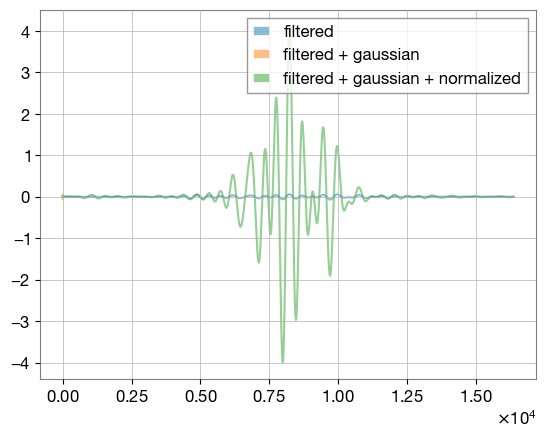

In [31]:
%matplotlib inline
sample_rate=16384.
inj_length=1
seed=0
mode=0
frequency = 10
bandwidth = 10
duration = 0.1
np.random.seed(seed)

# Generate white gaussian noise 1 sec
x = np.random.normal(0, 1, int(inj_length * sample_rate))
dt = 1.0 / sample_rate
df = sample_rate / len(x)

# plt.plot(x, label="original")
# Apply a band limited cut in frequency
X = fft(x)


# Asymmetric respect to the central frequency
bLow = int(frequency / df)
bHigh = int((frequency + bandwidth) / df)
X[:2 * bLow] = 0
X[2 * bHigh:2 * int(len(X) / 2)] = 0

x = ifft(X)
plt.plot(x, label="filtered", alpha=0.5)

# Apply a gaussian shape in time
function_range = 1.
t = np.linspace(0, inj_length, len(x))
gaussian_envelope = np.exp(-((t - function_range / 2) / duration) **2)
# gaussian_envelope = norm.pdf(t, 0, duration)
# plt.plot(gaussian_envelope, label="gaussian")
x *= gaussian_envelope

plt.plot(t, x, label="filtered + gaussian", alpha=0.5)

# Normalization
hrss = np.sqrt(np.sum(x.real ** 2) * dt)
x = (1. / np.sqrt(2.)) * x / hrss

plt.plot(x, label="filtered + gaussian + normalized", alpha=0.5)
plt.legend()
plt.show()